In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [2]:
# Проект 5. Компьютер говорит «Нет» 

# Проект 5. Компьютер говорит «Нет» 

In [3]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

In [4]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [5]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

## Первичный осмотр данных

In [6]:
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
train = pd.read_csv(DATA_DIR+'/train.csv')
test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [7]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

(None, None)

In [8]:
train.columns, test.columns

(Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
        'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
        'region_rating', 'home_address', 'work_address', 'income', 'sna',
        'first_time', 'foreign_passport', 'default'],
       dtype='object'),
 Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
        'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
        'region_rating', 'home_address', 'work_address', 'income', 'sna',
        'first_time', 'foreign_passport'],
       dtype='object'))

In [9]:
train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


Описания полей датасета

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

In [10]:
sample_submission.info()
print(sample_submission.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24354 entries, 0 to 24353
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  24354 non-null  int64  
 1   default    24354 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 380.7 KB
(24354, 2)


In [11]:
sample_submission.head()

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='default', ylabel='count'>

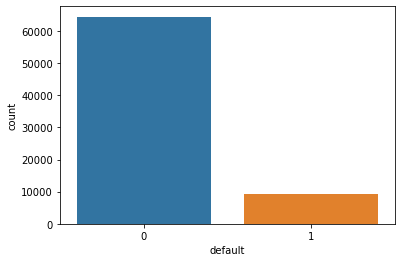

In [12]:
# Посмотрим на рспределение признака default в обучающей выбоке
sns.countplot(train['default'])

Видим, что распределение неравномерное. Клиентов, которым выдают кредит,намного больше.

In [13]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1   # обучающая выборка
test['sample'] = 0    # тестовая выборка
test['default'] = 0  # в тесте у нас нет значения default, мы его должны предсказать, 
# по этому пока просто заполняем нулями
data = train.append(test, sort=False).reset_index(drop=True)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [15]:
display(data)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,83775,31MAR2014,SCH,F,37,N,N,1,0,-1.744976,3,50,2,3,15000,4,1,N,0,0
110144,106254,25APR2014,GRD,F,64,Y,Y,0,0,-2.293781,3,60,1,2,200000,1,4,N,0,0
110145,81852,30MAR2014,GRD,M,31,N,N,2,0,-0.940752,1,50,1,2,60000,4,2,N,0,0
110146,1971,07JAN2014,UGR,F,27,N,N,1,0,-1.242392,2,80,2,3,30000,1,1,N,0,0


In [16]:
num_cols = ['age','decline_app_cnt','score_bki','income','bki_request_cnt','region_rating'] # Числовые переменные
cat_cols = ['education','work_address','home_address','sna','first_time'] # категориальные переменные
bin_cols = ['sex','car','car_type','good_work','foreign_passport'] # бинарные переменные

## Подготовка данных

Как мы видим, пропуски встречаются только в информации об образовании клиентов. Посмотрим на признак ближе:

<AxesSubplot:>

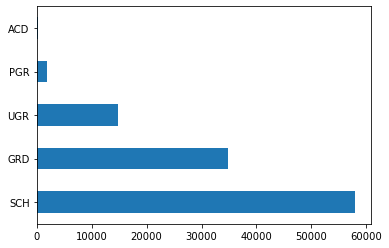

In [17]:
data.education.value_counts().plot.barh()

Заполним пропуски unknown

In [18]:
data['education'] = data['education'].fillna('unknown')
data['education'].value_counts()

SCH        57998
GRD        34768
UGR        14748
PGR         1865
unknown      478
ACD          291
Name: education, dtype: int64

Смотрим на распределение числовых признаков 

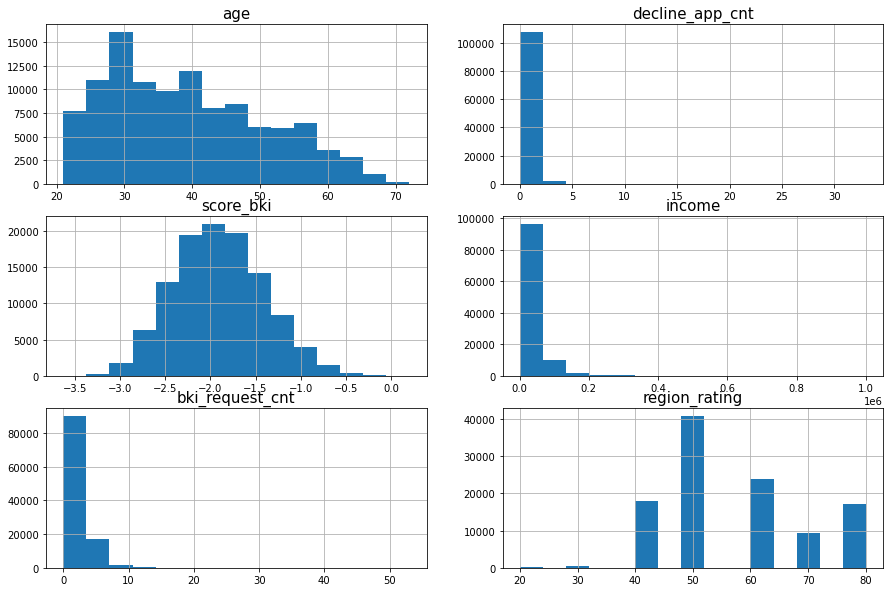

In [19]:
plt.figure(figsize=(15,10))
for i, col in enumerate(num_cols):
    plt.subplot(3,2, i+1)
    data[col].hist(bins=15)
    plt.title(col, fontsize=15)

После построения гистограмм стало очевидно, что распределения всех числовых переменных имеют тяжёлый правый хвост. Кроме распределения признака bki_request_cnt. Построим графики распределения логарифмированных переменных.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


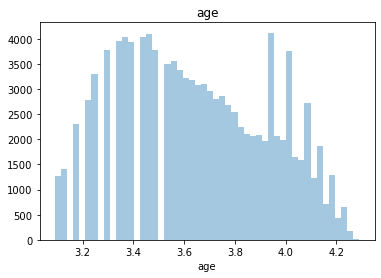

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


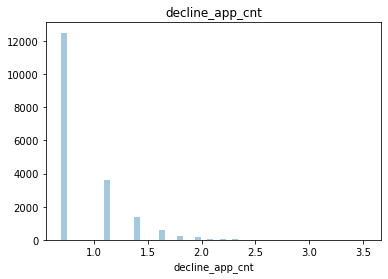

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


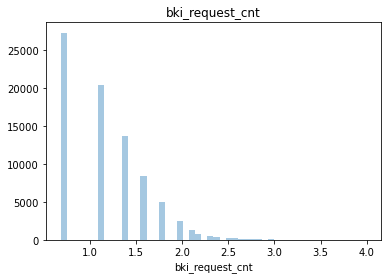

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


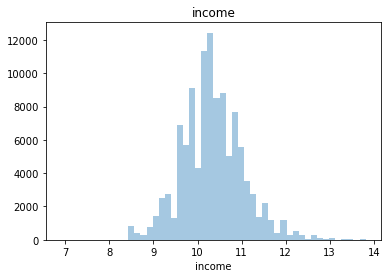

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


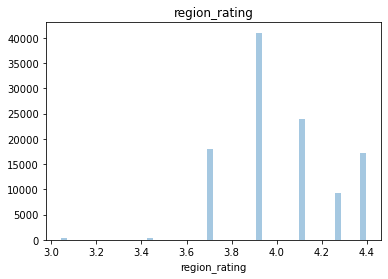

In [20]:
data['age'] = data['age'].apply(lambda w: np.log(w + 1))
data['decline_app_cnt'] = data['decline_app_cnt'].apply(lambda w: np.log(w + 1))
data['bki_request_cnt'] = data['bki_request_cnt'].apply(lambda w: np.log(w + 1))
data['income'] = data['income'].apply(lambda w: np.log(w + 1))
data['region_rating'] = data['region_rating'].apply(lambda w: np.log(w + 1))
for i in ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'region_rating']:
    plt.figure()
    sns.distplot(data[i][data[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

Столбцы теперь выглядят лучше

## Анализ числовых признаков

Постороим бохплоты для численных переменных:

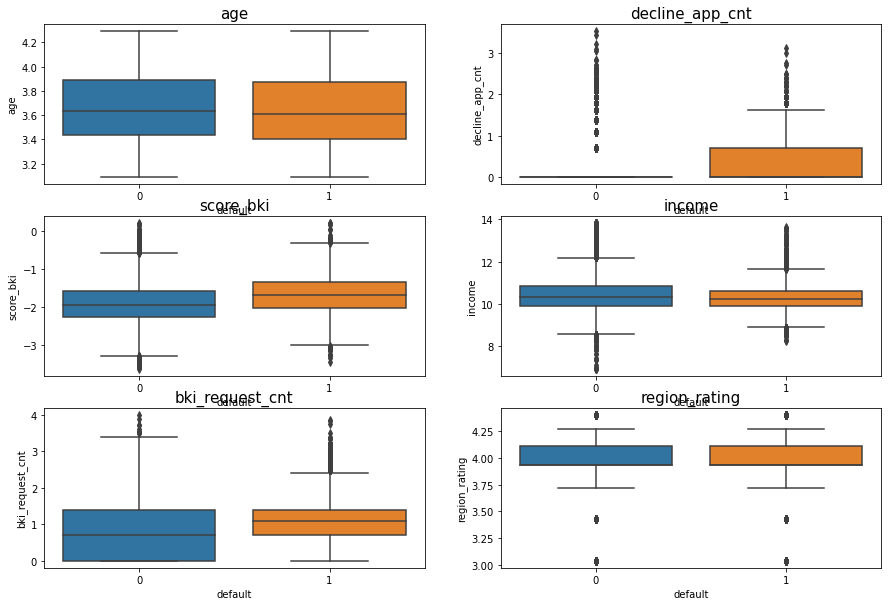

In [21]:
plt.figure(figsize=(15,10))
for i, col in enumerate(num_cols):
    plt.subplot(3,2, i+1)
    sns.boxplot(x = 'default', y = col, data = data)
    plt.title(col, fontsize=15)

- Дефолтные клиенты в среднем младше недефолтных
- Дефолтные клиенты в среднем имеют большое количество отмененных заявок
- Скоринговый балл выше у дефолтных клиентов 
- Дефолтные клиенты в среднем имеют больше запросов в БКИ
- Дефолтные клиенты в среднем имеют более низкий доход
- Рейтинг региона одинаковый

Посмотрим на матрицу корреляций:

In [22]:
data_corr = data.drop(['client_id','education', 'sex', 'car', 'car_type', 'good_work', 'home_address',
                        'work_address', 'foreign_passport', 'default','sna','first_time','sample'], axis=1)

<AxesSubplot:>

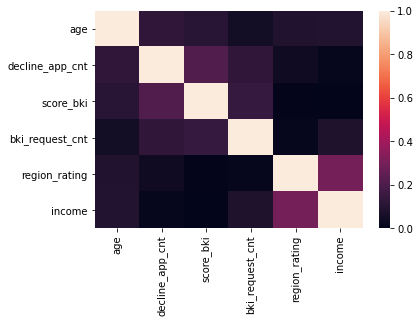

In [23]:
sns.heatmap(data_corr.corr().abs(), vmin=0, vmax=1)

Высокой корреляции между признаками не наблюдается

### Оценка значимости непрерывных переменных

<AxesSubplot:>

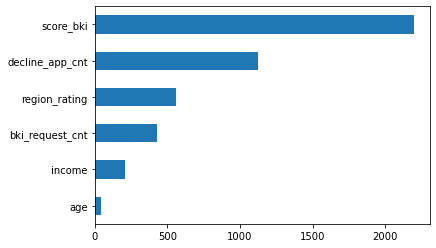

In [24]:
imp_num = Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Самым значимым является признак score_bki

## Анализ категориальных переменных

Преобразуем все бинарные признаки в числа 0 и 1.

In [25]:
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
# убедимся в преобразовании    
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
0,25905,01FEB2014,SCH,1,4.143135,1,1,0.000000,0,-2.008753,0.693147,3.931826,1,2,9.798183,4,1,0,0,1
1,63161,12MAR2014,SCH,0,4.094345,0,0,0.000000,0,-1.532276,1.386294,3.931826,2,3,9.852247,4,1,0,0,1
2,25887,01FEB2014,SCH,1,3.258097,1,0,1.098612,0,-1.408142,0.693147,4.394449,1,2,10.308986,1,4,1,0,1
3,16222,23JAN2014,SCH,0,3.988984,0,0,0.000000,0,-2.057471,1.098612,3.931826,2,3,9.210440,1,3,0,0,1
4,101655,18APR2014,GRD,1,3.891820,0,0,0.000000,1,-1.244723,0.693147,4.110874,2,3,10.308986,1,4,1,0,1


Теперь преобразуем категориальные переменные. Начнем со столбца с датами.

In [26]:
data['app_date'] = pd.to_datetime(data.app_date)

In [27]:
data['app_date'].sample(3)

2157    2014-02-18
99667   2014-02-10
46955   2014-03-26
Name: app_date, dtype: datetime64[ns]

Теперь можем посчитать количество дней, прошедших с самой первой даты в нашем датасете.

In [28]:
data['app_date'] = data['app_date'].apply(lambda x: (x - data['app_date'].min()).days) 

In [29]:
# теперь преобразуем признак education в числа

data['education'] = label_encoder.fit_transform(data['education'])
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
0,25905,31,3,1,4.143135,1,1,0.000000,0,-2.008753,0.693147,3.931826,1,2,9.798183,4,1,0,0,1
1,63161,70,3,0,4.094345,0,0,0.000000,0,-1.532276,1.386294,3.931826,2,3,9.852247,4,1,0,0,1
2,25887,31,3,1,3.258097,1,0,1.098612,0,-1.408142,0.693147,4.394449,1,2,10.308986,1,4,1,0,1
3,16222,22,3,0,3.988984,0,0,0.000000,0,-2.057471,1.098612,3.931826,2,3,9.210440,1,3,0,0,1
4,101655,107,1,1,3.891820,0,0,0.000000,1,-1.244723,0.693147,4.110874,2,3,10.308986,1,4,1,0,1


## Оценка значимости категориальных признаков 

<AxesSubplot:>

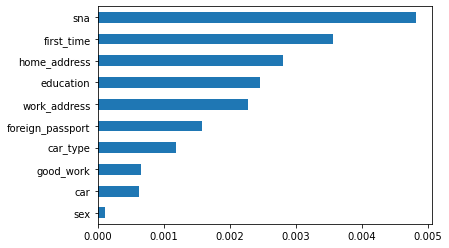

In [30]:
imp_cat = Series(mutual_info_classif(data[cat_cols + bin_cols], data['default'],
                                     discrete_features =True), index = cat_cols + bin_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Наиболее значимый признак sna - связь заемщика с клиентами банка

## Подготовка данных к машинному обучению

Перед обучением регрессии нам следует стандартизировать числовые признаки, а также воспользоваться dummy-кодированием для категориальных переменных, то есть создать отдельную бинарную переменную для каждой категории.

In [31]:
X_cat = OneHotEncoder(sparse = False).fit_transform(data[cat_cols].values)

In [32]:
X_cat.shape

(110148, 20)

Стандартизируем числовые переменные:

In [33]:
X_num = StandardScaler().fit_transform(data[num_cols].values)

И объединим стандартизованные числовые, бинарные и закодированные категориальные переменные в одно признаковое пространство, разделив при этом признаки и целевую переменную.

In [34]:
X = np.hstack([X_num, data[bin_cols].values, X_cat])
Y = data['default'].values

## Обучение и оценка качества модели

Разделим данные для обучения следующим образом:

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [36]:
model = LogisticRegression(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]
round(roc_auc_score(y_test, probs), 3)

0.72

Оценим производительность модели по рабочей характеристике ROC.

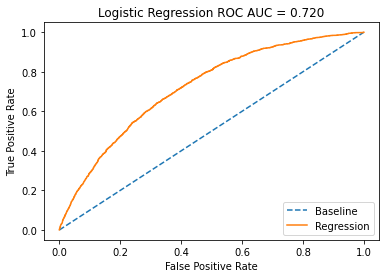

In [37]:
def plot_roc_curve(y_true, y_score):
    fpr, tpr, threshold = roc_curve(y_true, y_score)
    roc_auc = roc_auc_score(y_true, y_score)
    
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()
    
plot_roc_curve(y_test, probs)

Производительность нашей модели кажется неплохой, построим Confusion Matrix:

In [38]:
from sklearn.metrics import plot_confusion_matrix


def plot_cmatrix(estimator, X, y, title=None, **kwargs):
    disp = plot_confusion_matrix(model, X_test, y_test, **kwargs)
    disp.ax_.set_ylabel('Истинный класс')
    disp.ax_.set_xlabel('Предсказанный класс')
    if title:
        disp.ax_.set_title(title)

In [39]:
def plot_grid(nplots, max_cols=2, figsize=(800/72, 600/72)):
    ncols = min(nplots, max_cols)
    nrows = (nplots // ncols) + min(1, (nplots % ncols))
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize, constrained_layout=True)
    if nrows == 1:
        return axs
    return [axs[index // ncols, index % ncols] for index in range(nplots)]

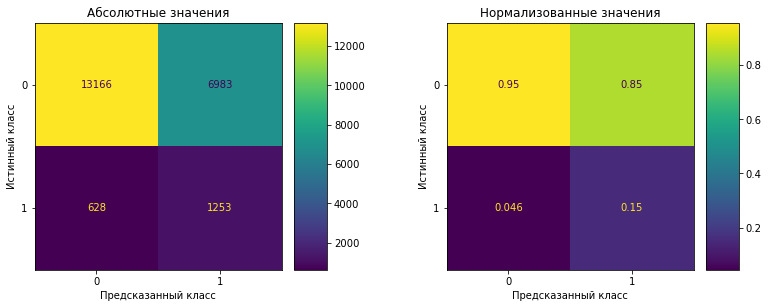

In [40]:
axs = plot_grid(2, figsize=(800/72, 300/72))
plot_cmatrix(model, X_test, y_test, title='Абсолютные значения', display_labels=['0', '1'], ax=axs[0]);
plot_cmatrix(model, X_test, y_test, title='Нормализованные значения', normalize='pred', display_labels=['0', '1'], ax=axs[1]);

Высокая доля ложно опрееленных недефолтных клиентов, то есть банк может понести убытки выдав им кредит. 

Попробуем использовать LogisticRegressionCV

In [41]:
model = LogisticRegressionCV(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]
round(roc_auc_score(y_test, probs), 3)

0.716

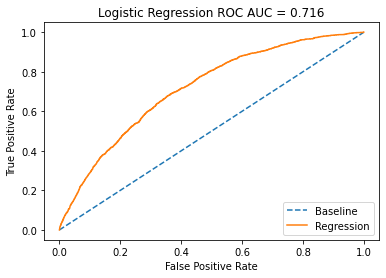

In [42]:
plot_roc_curve(y_test, probs)

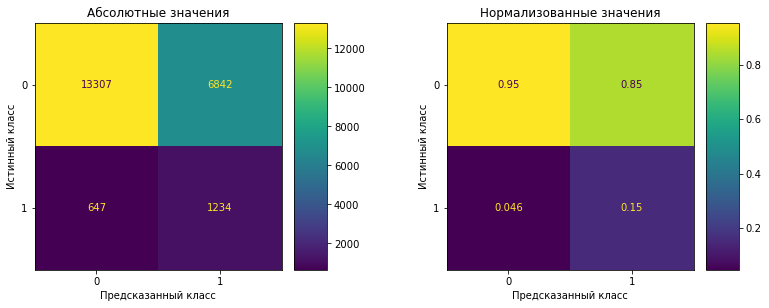

In [43]:
axs = plot_grid(2, figsize=(800/72, 300/72))
plot_cmatrix(model, X_test, y_test, title='Абсолютные значения', display_labels=['0', '1'], ax=axs[0]);
plot_cmatrix(model, X_test, y_test, title='Нормализованные значения', normalize='pred', display_labels=['0', '1'], ax=axs[1]);

## Подбор оптимального параметра для регуляризации

In [44]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for

Лучшее Penalty: l2
Лучшее C: 1.0


In [45]:
probs = best_model.predict_proba(X_test)
probs = probs[:,1]
round(roc_auc_score(y_test, probs), 3)

0.72

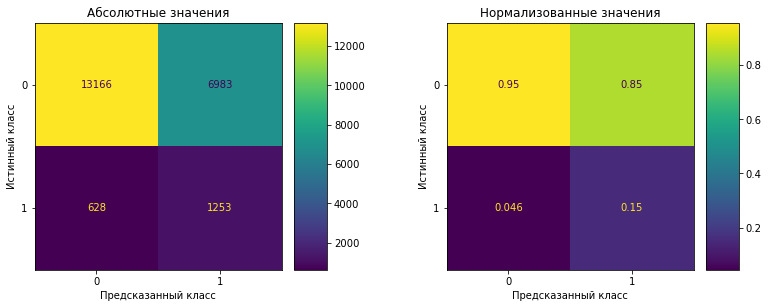

In [46]:
axs = plot_grid(2, figsize=(800/72, 300/72))
plot_cmatrix(best_model, X_test, y_test, title='Абсолютные значения', display_labels=['0', '1'], ax=axs[0]);
plot_cmatrix(best_model, X_test, y_test, title='Нормализованные значения', normalize='pred', display_labels=['0', '1'], ax=axs[1]);

В целом значение параметров существенно не изменилось. 

Опубликуем данные:

In [47]:
train_data = data.query('sample == 1').drop(['sample','client_id'], axis=1)
test_data = data.query('sample == 0').drop(['sample','client_id'], axis=1)

In [48]:
X_train = train_data.drop(['default'], axis=1)
y_train = train_data.default.values
X_test = test_data.drop(['default'], axis=1)

In [49]:
test_data.shape, train_data.shape, X_train.shape, y_train.shape, X_test.shape

((36349, 18), (73799, 18), (73799, 17), (73799,), (36349, 17))

In [50]:
last_model = LogisticRegression(random_state=42, class_weight='balanced')

last_model.fit(X_train, y_train)
probs = last_model.predict_proba(X_test)
probs = probs[:,1]

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [51]:
submit = pd.DataFrame(test.client_id)
submit['default'] = probs
submit.to_csv('submission.csv', index=False)

In [52]:
display(submit)

,client_id,default
0,74835,0.197842
1,17527,0.767077
2,75683,0.317948
3,26883,0.384685
4,28862,0.229794
...,...,...
36344,83775,0.760776
36345,106254,0.183205
36346,81852,0.784595
36347,1971,0.743152
